# Algo Pärt: algorithmic recomposition of _Summa_

_Bas Cornelissen_

_Last updated on 1 February 2022_

This notebook summarizes the code needed to algorithmically reconstruct a score for Arvo Pärt's 1977 composition _Summa_ for SATB choir a capella. To keep this notebook short, it does not contain examples illustrating the various steps (other notebook cover cover most steps in more detail). Also, we have moved some 'utility' code to a separate `utils.py` file. This is mostly code required to properly construct a score in music21, which is not our main concern here. Still, the majority of this notebook deals with 'administration': organizing all material so that we can generate a score. The amount of code needed to construct the melodies, our central interest, is very small: most work is done under the hood, in the `tintinnabuli` package.

In [1]:
from copy import deepcopy

import music21
from music21.note import Note
from music21.pitch import Pitch
from music21.chord import Chord
from music21.scale import MinorScale
from music21.key import KeySignature
from music21.stream import Stream

import sys
sys.path.append('../../')

from tintinnabulipy import MelodicSpace
from tintinnabulipy import TintinnabuliSpace
from tintinnabulipy import glue, rotate_tail, concatenate
from tintinnabulipy import StepProcess, OrnamentProcess, TailRotatedPatternProcess

from utils import syllabify
from utils import init_SATB_score
from utils import set_time_signatures
from utils import add_rehearsal_marks
from utils import insert_breathmark

## Step 1: Credo

We load the text of the _Credo_ from a separate text file. It has already been segmented in syllables, words and phrases, and we parse that here and extract a list of syllables.

In [2]:
# Load and segment the text of the Credo
with open('../credo.txt', 'r') as file:
    credo = file.read()
syllables = syllabify(credo)

In [3]:
# This is now a list of syllables (with hyphens)
syllables[:5]

['Cre-', 'do', 'in', 'u-', 'num']

## Step 2: Set up the pitch spaces

In [4]:
# The melodic spaces
M = MelodicSpace(MinorScale('E4'))
T = TintinnabuliSpace(Chord(['E4', 'G4', 'B4']))

## Step 3: Construct the main melodic material

The main melodic voice is the alto. This is created by repeating a 16-note pattern 16 times, but each time rotating the 'tail' of the pattern one step to the left. (The tail is everything that comes after the first note.) The basic pattern basically walks down and up a E natural minor scale. It can be constructed in various ways and we here choose to use Hillier's four _modes_.

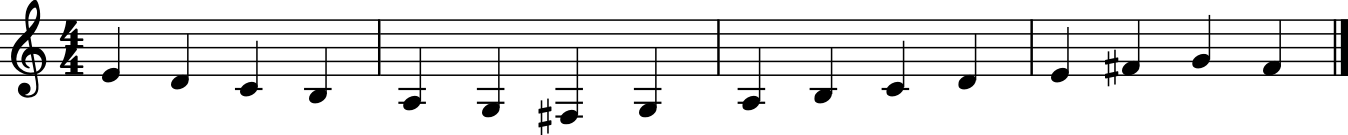

In [5]:
# The main melodic pattern of the alto
alto_pattern = glue(M.mode2(6), M.mode4(6), M.mode1(2), M.mode3(2))[:-1]
Stream([Note(n) for n in alto_pattern]).show()

In [6]:
# Repeat while rotating the tail
repetitions = [rotate_tail(alto_pattern, i) for i in range(16)]
alto = concatenate(*repetitions)

The bass mirrors the alto:

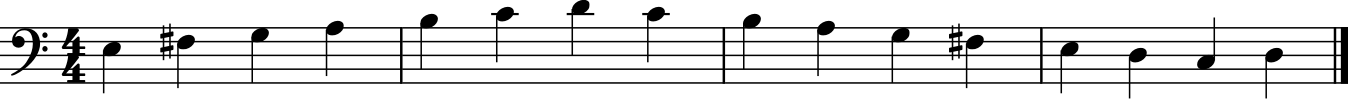

In [7]:
bass = M.transpose(M.mirror(alto), -7)
Stream([Note(n) for n in bass[:16]]).show()

The tintinnabuli voices, tenor and soprano, are constructed using what we called a _Step (Tintinnabuli) Process_. This process moves around stepwise in the tintinnabuli space (i.e., to neighbouring traid notes), while maintaining at least a certain tintinnabuli position with respect to the melody. For the soprano that is at least position 2, for the tenor at least position 1.

In [8]:
# tintinnabuli voices
soprano = StepProcess(T, position=2)(alto)
tenor = StepProcess(T, position=1)(bass, p0=2)

In [9]:
# Administration: collect in one object
voices = dict(S=soprano, A=alto, T=tenor, B=bass)

## Step 3: Add ornaments

The ornamentation is perhaps the hardest part of Summa. We have chosen to describe the ornamentation of the tintinnabuli and melody voices in two different ways, as two separate tintinnabuli processes. For the tenor and soprano that is a so called _ornament process_: this ornaments a note with the previous note if this is not equal to the next note, while keeping within a certain melodic range. The process for the alto and bass is in a way more ad hoc: it basically repeats a pattern of ornamentation for the basic 16 note pattern. Since that pattern is repeated with tail rotation, the tintinnabuli process for the ornamentation also has to perform a tail rotation. But in the end, the regularity we have encoded is essentialy repeating a 16-note ornamentation pattern.

In [10]:
# Ornaments
ornaments = dict()
sop_process = OrnamentProcess(T, 'E4', 'E5', max_target='E5')
ornaments['S'] = sop_process(soprano, t0=False)

ten_process = OrnamentProcess(T, 'E3', 'E4', max_target='B3')
ornaments['T'] = ten_process(tenor, t0=False)

alto_pattern = [False, 'G3', False, False, False, 'B3', False, 'E3', False, False, 'B3', False, False, False, False, False]
alto_process = TailRotatedPatternProcess(T, alto_pattern)
ornaments['A'] = alto_process(alto, t0=False)

bass_pattern = [False, False, 'E3', False, False, 'B3', False, 'G3', False, False, 'E3', False, False, False, False, 'B2']
bass_process = TailRotatedPatternProcess(T, bass_pattern)
ornaments['B'] = bass_process(bass, t0=False)

## Step 4: Organize the melody and text in measures

With the melodic material in place, we need to fill up a score: distribute the notes, ornaments and syllables over the measures according to the struture of _Summa_. The next function does exactly that.

In [11]:
def summa_structure(voicings, lengths, voices, ornaments, syllables):
    """Generates an object describing the structure of Summa. Outputs 
    a list of measures, where every measure is a dictionary containing the
    syllables sung in that measure, their durations (in quarter notes), 
    and the notes and ornaments for all for voices. The output of this
    function is then used to generate an actual score."""
    voices = deepcopy(voices)
    ornaments = deepcopy(ornaments)
    syllables = deepcopy(syllables)

    measures = []
    for voicing, length in zip(voicings, lengths):
        
        # Object containing all info about a single measure
        measure = dict(
            syllables=[],
            durations=[],
            S=dict(notes=[], ornaments=[]),
            A=dict(notes=[], ornaments=[]),
            T=dict(notes=[], ornaments=[]),
            B=dict(notes=[], ornaments=[])
        )
        
        for i in range(length):
            if len(syllables) > 0:
                measure['syllables'].append(syllables.pop(0))
                
            for voice in 'SATB':
                if voice in voicing:
                    note = voices[voice].pop(0)
                    ornament = ornaments[voice].pop(0)
                else:
                    note = False
                    ornament = False
                measure[voice]['notes'].append(note)
                measure[voice]['ornaments'].append(ornament)
            
            # Compute syllable duration
            alto_orn = measure['A']['ornaments'][i] is not False
            bass_orn = measure['B']['ornaments'][i] is not False
            duration = 2 if bass_orn or alto_orn else 1
            measure['durations'].append(duration)
            
        measures.append(measure)        
    return measures

In [12]:
# Which voices sing in each measure, and how many syllables does it contain?
voicings = 8 * ['SA', 'SATB', 'TB', 'TB', 'SATB', 'SA']
lengths = 8 * [7, 9, 7, 7, 9, 7]

In [13]:
# Organize notes, ornaments and syllables in the structure of Summa
structure = summa_structure(voicings, lengths, voices, ornaments, syllables)

### Example

In [14]:
# Syllables in measure 1
measure1 = structure[0]
measure1['syllables']

['Cre-', 'do', 'in', 'u-', 'num', 'de-', 'um,']

In [15]:
# Alto notes in measure 1
measure1['A']['notes']

[<music21.pitch.Pitch E4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch C4>,
 <music21.pitch.Pitch B3>,
 <music21.pitch.Pitch A3>,
 <music21.pitch.Pitch G3>,
 <music21.pitch.Pitch F#3>]

In [16]:
# Bass notes in measure 2
measure1['B']['notes']

[False, False, False, False, False, False, False]

## Step 5: Generate a score

The structure object is now used to create a score in music21. The only part of the 'core logic' that we still have to deal with, is the rhythm. We have already computed _syllable_ durations, and only in this final step we turn those into _note_ durations. Other than that, we are really only moving music21 objects to their right places.

In [17]:
def generate_score(structure):
    """Build a score from the measures object"""
    
    # Initialize the score
    meta = music21.metadata.Metadata()
    meta.title = 'Summa: an algoritmic reconstruction'
    meta.composer = 'Algo Pärt by Bas Cornelissen'
    meta.lyricist = 'Original by Arvo Pärt'
    key = music21.key.KeySignature(1)
    score = init_SATB_score(key, meta)
    
    # Iterate over all measures and fill them part by part
    for i, info in enumerate(structure):
        m = i + 1
        for part in score.parts:

            # Insert the measure
            if part.measure(m) is None:
                part.append(music21.stream.Measure())
            
            # Add all syllables to this voice
            voice = info[part.id[0].upper()]        
            details = zip(voice['notes'], voice['ornaments'], info['durations'], info['syllables'])
            for note_pitch, ornament_pitch, duration, syllable in details:

                if note_pitch is False:
                    # This voice is not singing this syllable, so skip.
                    continue

                note = Note(note_pitch)
                note.lyric = syllable

                if ornament_pitch is False:
                    # No ornament, just one note
                    note.quarterLength = duration
                    part.measure(m).append(note)

                else:
                    # Insert note and ornament, both of half the syllable duration
                    ornament = Note(ornament_pitch)
                    note.quarterLength = duration / 2
                    ornament.quarterLength = duration / 2
                    part.measure(m).append(note)
                    part.measure(m).append(ornament)

                    # Add slur
                    slur = music21.spanner.Slur([note, ornament])
                    part.measure(m).append(slur)

                # Insert breathmark
                if syllable[-1] in '.,:':
                    insert_breathmark(part.measure(m).notes[-1])

    # Finalize score: add (hidden) time signatures and rehearsal marks
    set_time_signatures(score)
    add_rehearsal_marks(score)  
    return score

In [18]:
# Build a score from the structure object. 
# This can take a while...
score = generate_score(structure)

In [19]:
score.write(fp='../scores/Summa-reconstruction.musicxml')

PosixPath('/Users/bas/repos/projects/algo-part/summa/scores/Summa-reconstruction.musicxml')

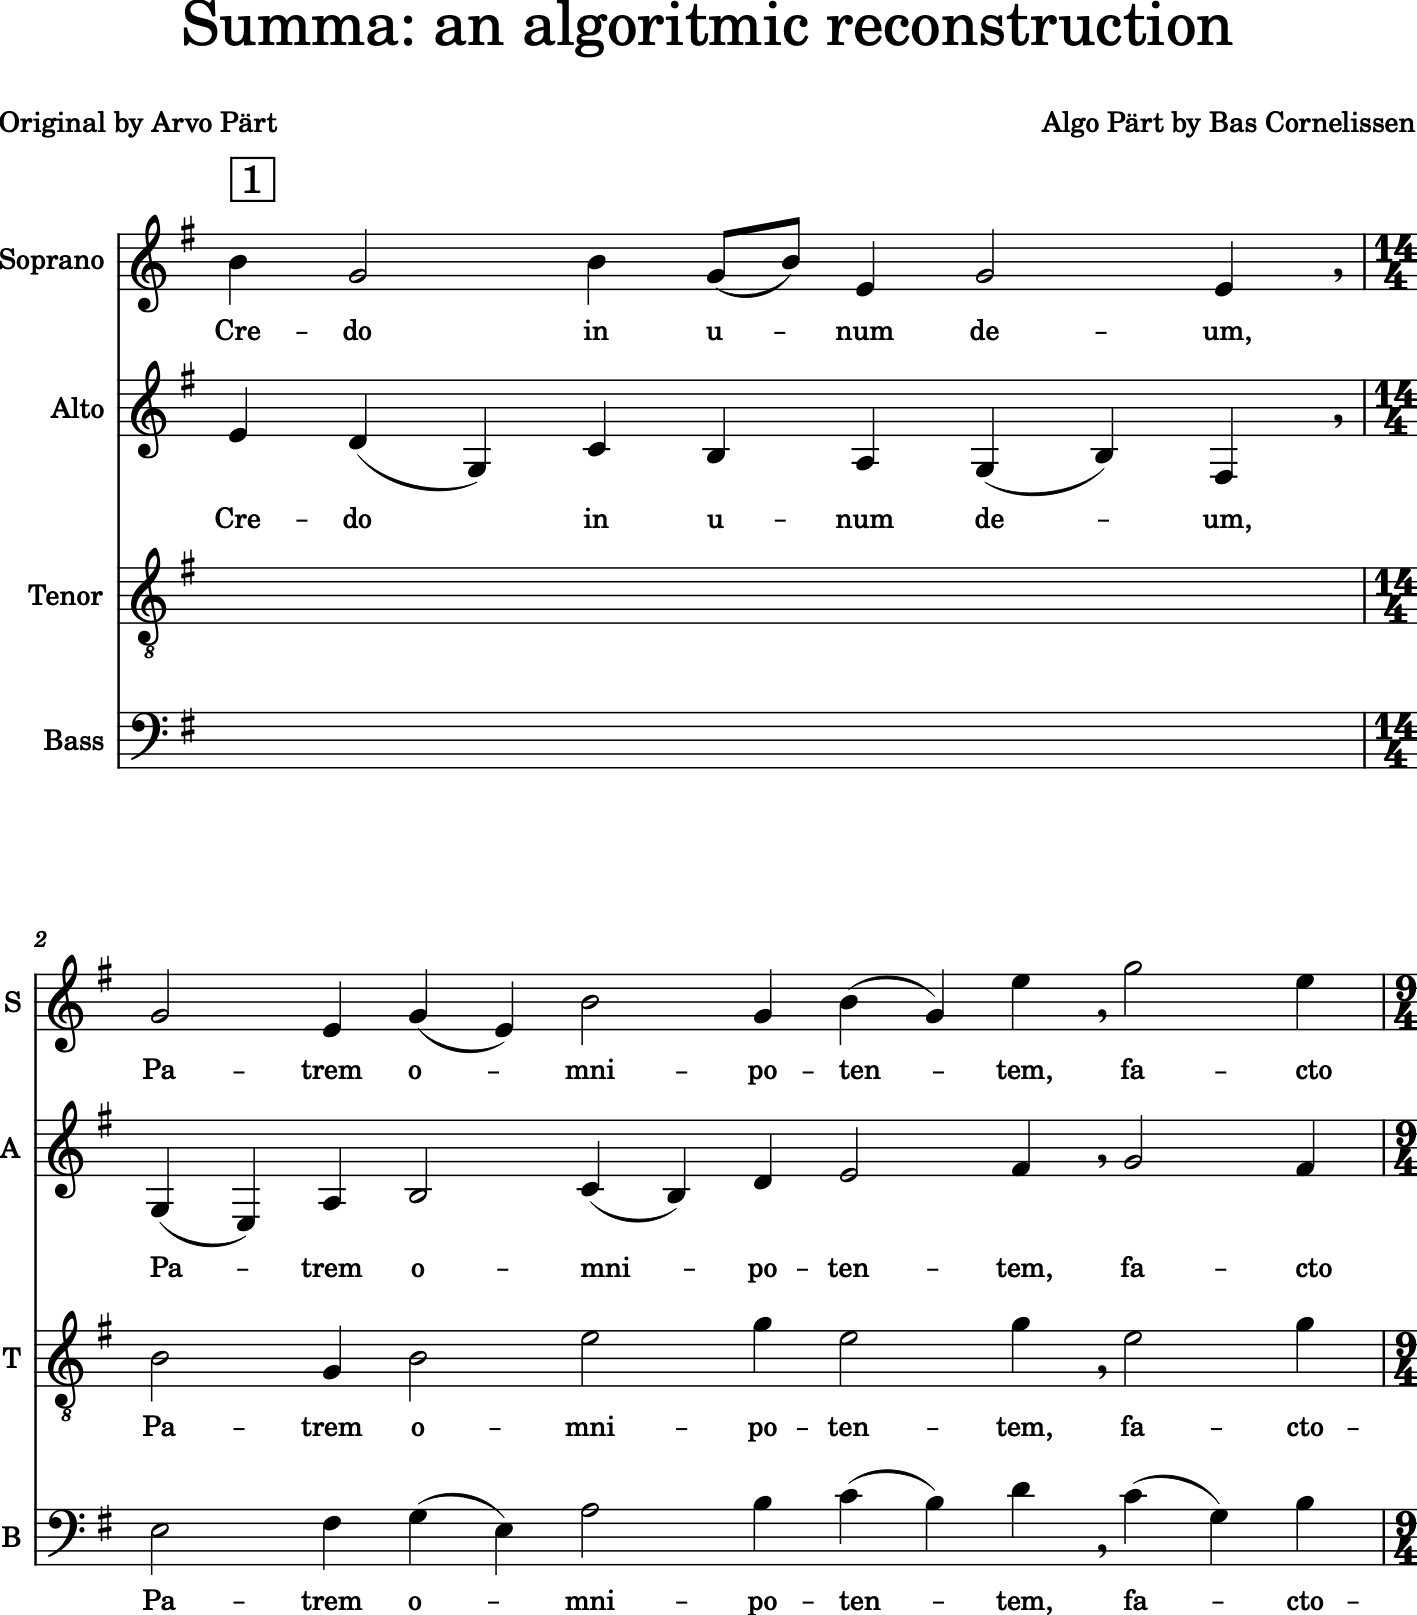

In [20]:
score.measures(1, 4).show()